# Import dataset

In [ ]:
# colab input path
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/woa 7015 group/alternative assignment/datasets/diabetes_012_health_indicators_BRFSS2015.csv'

# csv_path = 'PATH NAME HERE'

Mounted at /content/drive


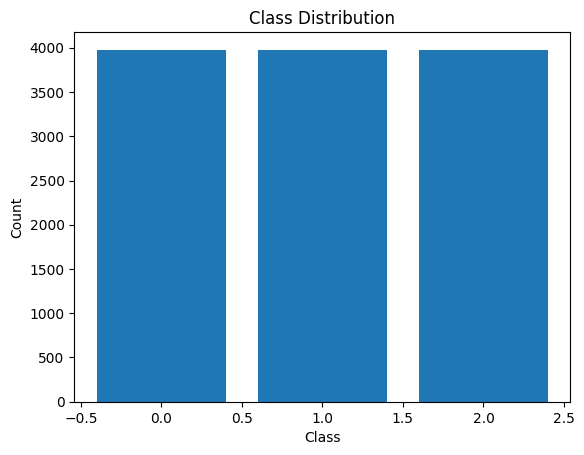

In [ ]:
#@title Import Data

import pandas as pd
import numpy as np
import torch

df = pd.read_csv(csv_path)

# extract last 15% of original dataset as test dataset
test_start_index = len(df) // 100 * 85
train_df = df.iloc[:test_start_index]
test_df = df.iloc[test_start_index + 1:]

min_class_count = train_df['Diabetes_012'].value_counts().min()
class_groups = [train_df[train_df['Diabetes_012'] == c] for c in train_df['Diabetes_012'].unique()]
downsampled_classes = [group.sample(n=min_class_count, random_state=42)
                        for group in class_groups]

train_df = pd.concat(downsampled_classes)

train_features = train_df.drop(columns=["Diabetes_012"])
train_labels = train_df["Diabetes_012"]

test_features = test_df.drop(columns=["Diabetes_012"])
test_labels = test_df["Diabetes_012"]

import matplotlib.pyplot as plt
import pandas as pd

count_class = train_labels.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
#@title Data Loader
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# data (as pandas dataframes)
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

class DiabetesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)  # Convert to tensor
        self.targets = torch.tensor(targets.values, dtype=torch.long)       # Convert to tensor for classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create Dataset
train_dataset = DiabetesDataset(X_train, y_train)
val_dataset = DiabetesDataset(X_val, y_val)
test_dataset = DiabetesDataset(test_features, test_labels)

Model code starting here

Use `train_dataset`, `val_dataset`, `test_dataset` as the input dataset

Train Dataset has

| Class | Count |
| --- | --- |
| 0.0 | 3978|
| 2.0 | 3978|
| 1.0 | 3978|

Test Dataset has

| Class | Count |
| --- | --- |
| 0.0 | 32427|
| 2.0 | 5039|
| 1.0 | 653|

Example below:

In [ ]:
#@title Logistic Regression

import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score

num_epochs = 500
batch_size = 32
init_weight = 0.5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


input_dim = train_features.shape[1]  # Number of features
output_dim = len(set(train_labels))  # Number of classes
model = LogisticRegressionModel(input_dim, output_dim)

# set initial weight
with torch.no_grad():
    model.linear.weight.fill_(init_weight)
    model.linear.bias.fill_(0.0)

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for features, targets in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    # Average training loss and accuracy for this epoch
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Average validation loss and accuracy for this epoch
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
      print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Testing Loop
y_true = []
y_pred = []

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for imbalanced datasets
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(train_losses)
axes[0].set(xlabel='Epoch',ylabel='Training Loss')

axes[1].plot(val_losses)
axes[1].set(xlabel='Epoch',ylabel='Validation Loss')
fig.tight_layout()

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes2[0].plot(train_accuracies)
axes2[0].set(xlabel='Epoch',ylabel='Training Accuracy')

axes2[1].plot(val_accuracies)
axes2[1].set(xlabel='Epoch',ylabel='Validation Accuracy')
fig2.tight_layout()


print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


accuracy = accuracy_score(test_labels, y_pred)
balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
f1_score_data = f1_score(test_labels, y_pred, average='weighted')
print(f'Test accuracy: {accuracy:.6f}')
print(f'Balanced Test accuracy: {balanced_accuracy:.6f}')
print(f'F1 score: {f1_score_data:.6f}')
print(f'{accuracy:.6f}')
print(f'{balanced_accuracy:.6f}')
print(f'{f1_score_data:.6f}')

In [ ]:
#@title Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)


model = RandomForestClassifier(
    n_estimators=2000,        # num of tree to generate
    max_depth=None,           # find until a pure leaf node is found
    class_weight="balanced",  # {balanced,balanced_subsample, or custom dict}
    random_state=42,
    max_features="sqrt",      # {sqrt,log2,None}
    oob_score=True,
    min_impurity_decrease=0.0,
    min_samples_split = 2,    # number of sample to split
    min_samples_leaf = 1      # number of sample in leaf node
)

# Train the model
model.fit(train_features, train_labels)

# Evaluate the model
y_pred = model.predict(test_features)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

accuracy = accuracy_score(test_labels, y_pred)
balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
f1_score_data = f1_score(test_labels, y_pred, average='weighted')
print(f'Test accuracy: {accuracy:.6f}')
print(f'Balanced Test accuracy: {balanced_accuracy:.6f}')
print(f'F1 score: {f1_score_data:.6f}')
print(f'{accuracy:.6f}')
print(f'{balanced_accuracy:.6f}')
print(f'{f1_score_data:.6f}')

In [ ]:
#@title Gradient Boosting

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

model = xgb.XGBClassifier(
    n_estimators=1000,                  # number of boosting rounds
    max_depth=10,                        # max tree depth for base learners
    max_leaves=0,                       # max leave
    learning_rate=0.001,                  # learning rate
    booster="gbtree",                   # gbtree, gblinear or dart
    tree_method="auto",                 # exact, approx, hist
    multi_strategy="multi_output_tree", # "one_output_per_tree" or "multi_output_tree"
    objective='multi:softmax',          # "multi:softprob", "multi:softmax"
    num_class=len(set(train_labels)),   # needed when use multi:softmax
    random_state=42
)

# Train the model
model.fit(train_features, train_labels)

# Evaluate the model
y_pred = model.predict(test_features)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

accuracy = accuracy_score(test_labels, y_pred)
balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
f1_score_data = f1_score(test_labels, y_pred, average='weighted')
print(f'Test accuracy: {accuracy:.6f}')
print(f'Balanced Test accuracy: {balanced_accuracy:.6f}')
print(f'F1 score: {f1_score_data:.6f}')
print(f'{accuracy:.6f}')
print(f'{balanced_accuracy:.6f}')
print(f'{f1_score_data:.6f}')